<a href="https://colab.research.google.com/github/2025-02-FML-team/WV-Team/blob/pretrained-comparison/notebooks/04_pretrained_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import shutil
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = Path('/content/unpacked/')
    PACK_DIR = Path('/content/drive/My Drive/colab_drive/prepacked.zip')
    shutil.copy(PACK_DIR, '/content/')
    !unzip -o -q /content/prepacked.zip -d {DATA_DIR}
else:
    DATA_DIR= Path(os.path.join(os.getcwd(), "../data/")).resolve()
DATA_DIR

Mounted at /content/drive


PosixPath('/content/unpacked')

In [3]:
import re
import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers

# CSV 로드 및 정리, 본인 경로에 맞게 변환
CSV_PATH = DATA_DIR / 'whiskies_recategorized.csv'
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 42

In [4]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMAGE_SIZE)
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/2943 [00:00<?, ?img/s]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 라벨 인코딩
labels = df["category"].values
le = LabelEncoder()
y_int = le.fit_transform(labels)

# test 분리
X_rest, X_test, y_rest, y_test = train_test_split(
    X, y_int,
    test_size=0.2,
    #random_state=RANDOM_STATE,
    stratify=y_int
)

# train / valid 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X_rest, y_rest,
    test_size=0.2,
    #random_state=RANDOM_STATE,
    stratify=y_rest
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test :", X_test.shape)

print("y_train 분포:", np.bincount(y_train))
print("y_valid 분포:", np.bincount(y_valid))
print("y_test  분포:", np.bincount(y_test))

print("class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

X_train: (1883, 256, 256, 3)
X_valid: (471, 256, 256, 3)
X_test : (589, 256, 256, 3)
y_train 분포: [316 148  97 468  49 147 155 503]
y_valid 분포: [ 79  37  24 117  12  37  39 126]
y_test  분포: [ 99  46  30 146  15  46  49 158]
class mapping: {'Blended': 0, 'Bourbon': 1, 'Brandy': 2, 'Other': 3, 'Rye': 4, 'SM_40_43': 5, 'SM_43_46': 6, 'SM_G46': 7}


In [6]:
X_train = X_train.astype("float32", copy=False)
X_valid = X_valid.astype("float32", copy=False)
X_test = X_test.astype("float32", copy=False)
X_train /= 255;
X_valid /= 255;
X_test /= 255;

### Pre-exsisting models builder
이미 잘 알려진 모델과의 성능을 비교하는 차원에서, 동일한 데이터로 기성모델을 학습합니다.
예시로써는 MobileNet, EfficientNet등이 있겠습니다.

In [7]:
def build_mobilenet(input_shape=(256,256,3), num_classes=8):
    base = keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg",
    )
    base.trainable = False
    x = layers.Dense(256, activation="gelu")(base.output)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(base.input, output)
    return model

In [8]:
def build_efficientnet_b0(input_shape=(256,256,3), num_classes=8):
    base = keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg",
    )
    base.trainable = False
    x = layers.Dense(256, activation="gelu")(base.output)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(base.input, output)
    return model

In [9]:
def build_resnet50(input_shape=(256,256,3), num_classes=8):
    base = keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg",
    )
    base.trainable = False
    x = layers.Dense(256, activation="gelu")(base.output)
    x = layers.Dropout(0.3)(base.output)
    output = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(base.input, output)
    return model

In [10]:
MODEL_PATH = DATA_DIR / 'models' / 'model_mobilenetv2.keras'
CHECK_DIR = DATA_DIR / 'models' / 'chkpoint'

CHECK_DIR.mkdir(parents=True, exist_ok=True)

In [23]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val, start_from_epoch=12, patient=3):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = [] #this is for cumilating f1 per epoch
        self.start_from_epoch = start_from_epoch
        self.patient = patient
        self.out = 0
        self.best_f1 = -1

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        if self.y_val.ndim == 2:
            y_true = np.argmax(self.y_val, axis=1)
        else:
            y_true = self.y_val

        f1 = f1_score(y_true, y_pred, average='macro')
        self.f1_scores.append(f1)
        logs['val_macro_f1'] = f1

        if f1 > self.best_f1:
            self.best_f1 = f1

        if 1 < epoch and epoch > self.start_from_epoch and f1 < self.f1_scores[-2]:
            print(f"\nNon Improvement detected at EP : {epoch}, f1 : {f1}")
            self.out += 1

        if self.out >= self.patient:
            print(f"\nStopping at EP : {epoch}, f1 : {f1}")
            self.model.stop_training = True

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

f1_cb = F1ScoreCallback(X_valid, y_valid)

checkpoint = ModelCheckpoint(
    CHECK_DIR / f"chk_mobilenetv2.keras",
    monitor='val_macro_f1',
    save_best_only=True,
    mode='max'
)

In [25]:
mobilenet_model = build_mobilenet()
mobilenet_model.compile(optimizer=Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])

/tmp/ipython-input-4051411986.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(


In [26]:
history = mobilenet_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=128,
    callbacks=[f1_cb, checkpoint]
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3345 - loss: 1.9080 - val_accuracy: 0.4650 - val_loss: 1.4826 - val_macro_f1: 0.1989
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.5123 - loss: 1.3559 - val_accuracy: 0.5032 - val_loss: 1.3711 - val_macro_f1: 0.2705
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.5581 - loss: 1.2013 - val_accuracy: 0.5329 - val_loss: 1.2916 - val_macro_f1: 0.3487
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.6231 - loss: 1.0489 - val_accuracy: 0.5648 - val_loss: 1.2593 - val_macro_f1: 0.3896
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.6720 - loss: 0.9560 - val_accuracy: 0.5520 - val_loss: 1.2317 - val_macro_f1: 0.4442
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.7055 - loss: 0.8583 - val_accuracy: 0.5817 - val_loss: 1.1894 - val_macro_f1: 0.4471
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.7390 - loss: 0.7997 - val_accu

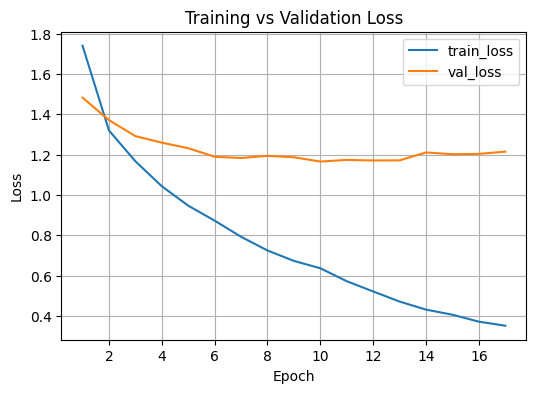

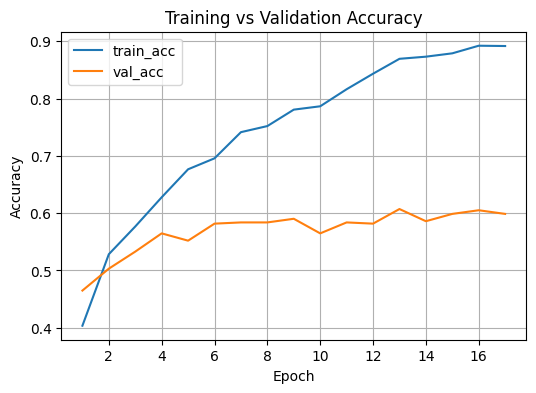

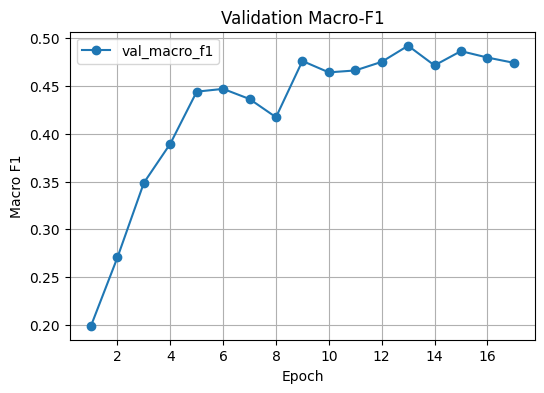

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# history → DataFrame 변환
hist = pd.DataFrame(history.history)

# Epoch index 만들기
epochs = range(1, len(hist) + 1)

# LOSS plot
plt.figure(figsize=(6,4))
plt.plot(epochs, hist["loss"], label="train_loss")
plt.plot(epochs, hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ACCURACY plot (있을 경우)
if "accuracy" in hist.columns:
    plt.figure(figsize=(6,4))
    plt.plot(epochs, hist["accuracy"], label="train_acc")
    plt.plot(epochs, hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Macro-F1 plot (커스텀 콜백 있을 경우)
if "val_macro_f1" in hist.columns:
    plt.figure(figsize=(6,4))
    plt.plot(epochs, hist["val_macro_f1"], marker='o', label="val_macro_f1")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1")
    plt.legend()
    plt.grid(True)
    plt.show()